In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import math
import Model
import warnings

warnings.simplefilter('ignore', FutureWarning)

if __name__ == "__main__":
	t = time.time()
	featureList = ['EPS Growth', 'Volatility 180 D', 'Trailing EPS', 'Price to Cash Flow', 'EPS', 'Volume', 'Return on Assets', 'Price to Book', 'Dividend Yield', 'Total Debt to Total Equity', 'Return on Invested Capital', 'Return on Common Equity']
	train, validate, test = Model.splitData(300,3,12)
	sector = "Consumer Discretionary"
	randForest = Model.buildWithIndexesTripleClass(modelType = Model.randomForestClassifier, indexes = train, target= 'Rate of Return', features = featureList, featureLength = 12,\
									targetLength = 3, sector = sector, percentileTarget = 90, percentileAvoid = 10, verbose = True)
	print(time.time() - t, "seconds wait time")
	print("Labels: ")
	print(randForest.classes_)
	print("Importances: ")
	print(randForest.feature_importances_)

[-268 -112 -223  -22 -121 -169 -109 -136  -34 -277 -286  -58 -250 -127 -139
 -232 -241 -115 -202 -175 -196  -31 -130 -283 -262 -253  -85  -16 -172  -43
  -25  -37 -295 -211 -259 -118 -181 -190 -220 -145 -235 -163 -154 -142 -274
  -73 -217  -70 -238 -280 -133  -64 -199 -205 -289 -124 -157]
[ -94 -160 -244  -49 -247 -148  -67  -46 -166  -82  -19 -298 -100  -52 -103
 -271  -28 -106 -226]
[-208  -97 -301 -292 -229 -178 -151 -184  -76  -79 -214  -40  -61 -193  -55
 -265 -256  -91  -88 -187]
Finished data retrieval, starting model training.
Finished fitting.
118.29323697090149 seconds wait time
Labels: 
[0 1 2]
Importances: 
[ 0.09707746  0.12196983  0.08364127  0.09227994  0.08357431  0.09364019
  0.04023344  0.09022613  0.03990163  0.08009167  0.08918497  0.08817916]


In [2]:
precisions = {'seen':{}, 'above10':{}, 'above75':{}, 'above50':{}, 'above25':{}, 'above90':{}}
betterThan = {}
for prob in range(0,100,5):
	precisions['seen'][prob] = 0
	precisions['above10'][prob] = 0
	precisions['above75'][prob] = 0
	precisions['above50'][prob] = 0
	precisions['above25'][prob] = 0
	precisions['above90'][prob] = 0
for i in validate:
	addedStocks, probabilities = Model.predict_probabilities(randForest, startIndex = i, endIndex = i+11, features = featureList, sector = sector)
	actual = []
	for prob in range(0,100,5):
		betterThan[prob] = []
	for stock in addedStocks:
		actual.append(Model.rateOfReturn(Model.retrieveData(stock, 'Last Price', i+12, i+14, [])))
	for i in range(len(probabilities)):
		for prob in range(0,100,5):
			if probabilities[i][1] > prob / 100:
				betterThan[prob].append(1)
			else:
				betterThan[prob].append(0)
	for prob in range(0,100,5):
		if sum(betterThan[prob]) > 0:
			precisions['above10'][prob] = (Model.precision(Model.getPercentile(actual, 10),betterThan[prob]) * len(betterThan[prob]) + precisions['above10'][prob] * precisions['seen'][prob]) / (precisions['seen'][prob] + len(betterThan[prob]))
			precisions['above75'][prob] = (Model.precision(Model.getPercentile(actual, 75),betterThan[prob]) * len(betterThan[prob]) + precisions['above75'][prob] * precisions['seen'][prob]) / (precisions['seen'][prob] + len(betterThan[prob]))
			precisions['above50'][prob] = (Model.precision(Model.getPercentile(actual, 50), betterThan[prob]) * len(betterThan[prob]) + precisions['above50'][prob] * precisions['seen'][prob]) / (precisions['seen'][prob] + len(betterThan[prob]))
			precisions['above25'][prob] = (Model.precision(Model.getPercentile(actual, 25), betterThan[prob]) * len(betterThan[prob]) + precisions['above25'][prob] * precisions['seen'][prob]) / (precisions['seen'][prob] + len(betterThan[prob]))
			precisions['above90'][prob] = (Model.precision(Model.getPercentile(actual, 90), betterThan[prob]) * len(betterThan[prob]) + precisions['above90'][prob] * precisions['seen'][prob]) / (precisions['seen'][prob] + len(betterThan[prob]))
			precisions['seen'][prob] = precisions['seen'][prob] + len(betterThan[prob])
x = []
y90 = []
y75 = []
y50 = []
y25 = []
y10 = []
counts = []
for prob in range(0,100,5):
	print(str(prob) + " above 90th percentile: " + str(precisions['above90'][prob]))
	print(str(prob) + " above 75th percentile: " + str(precisions['above75'][prob]))
	print(str(prob) + " above 50th percentile: " + str(precisions['above50'][prob]))
	print(str(prob) + " above 25th percentile: " + str(precisions['above25'][prob]))
	print(str(prob) + " above 10th percentile: " + str(precisions['above10'][prob]))
	counts.append(sum(betterThan[prob]))
	if (precisions['above10'][prob]) > 0:
		y90.append(precisions['above90'][prob])
		y75.append(precisions['above75'][prob])
		y50.append(precisions['above50'][prob])
		y25.append(precisions['above25'][prob])
		y10.append(precisions['above10'][prob])
		x.append(prob)

0 above 90th percentile: 0.101020356049
0 above 75th percentile: 0.24570107648
0 above 50th percentile: 0.485460629826
0 above 25th percentile: 0.725465597957
0 above 10th percentile: 0.871103018562
5 above 90th percentile: 0.135328725444
5 above 75th percentile: 0.294822675036
5 above 50th percentile: 0.517202254873
5 above 25th percentile: 0.734362841773
5 above 10th percentile: 0.878478958485
10 above 90th percentile: 0.168184400394
10 above 75th percentile: 0.320370557787
10 above 50th percentile: 0.519917682334
10 above 25th percentile: 0.72674796096
10 above 10th percentile: 0.868349886469
15 above 90th percentile: 0.183806071823
15 above 75th percentile: 0.343296256163
15 above 50th percentile: 0.536919987329
15 above 25th percentile: 0.728784783893
15 above 10th percentile: 0.860286023659
20 above 90th percentile: 0.205268042461
20 above 75th percentile: 0.361299503997
20 above 50th percentile: 0.55531590361
20 above 25th percentile: 0.72907632819
20 above 10th percentile: 0.85

Counts: 
[169, 124, 91, 63, 49, 42, 29, 21, 19, 18, 14, 7, 3, 2, 0, 0, 0, 0, 0, 0]


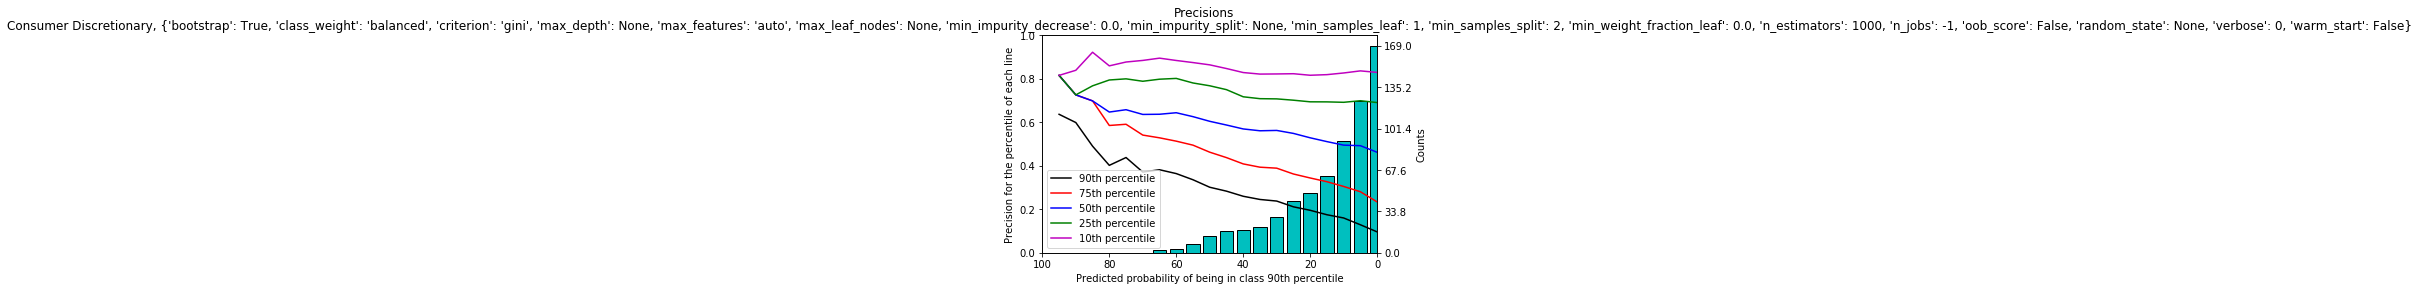

In [3]:
print("Counts: ")
print(counts)
fig = plt.figure()
axes = plt.gca()
axes.set_xlim([0,100])
axes.set_xlim([0,100])
plt.suptitle("Precisions")
plt.title(sector + ", " + str(randForest.get_params()))
plt.xlabel('Predicted probability of being in class 90th percentile')
plt.ylabel('Precision for the percentile of each line')
axes.invert_xaxis()
bar = axes.twinx()
rects = bar.bar(x = list(range(0,100,5)), height = list(map(lambda x: x/max(counts),counts)), width = 4, color = 'c', linestyle = 'solid', edgecolor = 'k', zorder = -1)
bar.set_yticklabels(list(map(lambda x: x * max(counts) / 5, range(0,6,1))))
bar.set_ylabel('Counts', color = 'k')
plt.plot(x, y90, color = 'k', label = "90th percentile")
plt.plot(x, y75, color = 'r', label = "75th percentile")
plt.plot(x, y50, color = 'b', label = "50th percentile")
plt.plot(x, y25, color = 'g', label = "25th percentile")
plt.plot(x, y10, color = 'm', label = "10th percentile")
plt.legend()

In [4]:
fig.savefig(str(time.time()) + 'test.jpg', dpi=900)
plt.show()

Feature ranking:
1. Volatility 180 D (0.121970)
2. EPS Growth (0.097077)
3. Volume (0.093640)
4. Price to Cash Flow (0.092280)
5. Price to Book (0.090226)
6. Return on Invested Capital (0.089185)
7. Return on Common Equity (0.088179)
8. Trailing EPS (0.083641)
9. EPS (0.083574)
10. Total Debt to Total Equity (0.080092)
11. Return on Assets (0.040233)
12. Dividend Yield (0.039902)


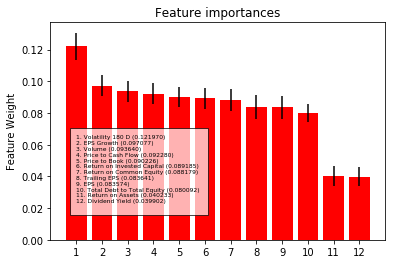

In [5]:
# adapted from http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

importances = randForest.feature_importances_
std = np.std([est.feature_importances_ for est in randForest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
textString = ''
for f in range(len(featureList)):
    print("%d. %s (%f)" % (f + 1, featureList[indices[f]], importances[indices[f]]))
    textString += "%d. %s (%f) \n" % (f + 1, featureList[indices[f]], importances[indices[f]])

# Plot the feature importances of the forest
fig2 = plt.figure()
plt.title("Feature importances")
plt.bar(range(len(featureList)), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(len(featureList)), range(1,len(featureList)+1))
plt.xlim([-1, len(featureList)])
plt.ylabel('Feature Weight')
plt.text(0, 0.02, textString,
        bbox={'facecolor':'white', 'alpha':0.7, 'pad':6}, fontsize=6)
fig2.savefig(str(time.time()) + 'feature_importances.jpg', dpi=900)
plt.show()